In [3]:
!pip install sdv pandas scikit-learn

In [9]:
# Install first
# pip install sdv pandas scikit-learn
import numpy as np
import pandas as pd
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer

# Step 1: Sample dataset
data = pd.read_csv('diabetes.csv')
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[cols_with_zero] = data[cols_with_zero].replace(0, np.nan)
data.fillna(data.mean(), inplace=True)  # Simple strategy: fill NaN with column mean

print(data.describe())





       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.435949      12.096346       8.790942   85.021108   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.202592      29.153420  155.548223   
75%       6.000000  140.250000      80.000000      32.000000  155.548223   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.457464                  0.471876   33.240885    0.348958  
std      6.875151                  0.331329   11.760232    0.476951  
min     18.200000                  

In [15]:
metadata = Metadata.detect_from_dataframe(
    data=data,
    table_name='diabetes')
# Step 2: Train model
model = CTGANSynthesizer( metadata, # required
    enforce_rounding=False,
    epochs=500,
    verbose=True)
model.fit(data)

# Step 3: Generate synthetic data
synthetic_data = model.sample(1000)

# Step 4: Check synthetic data
print(synthetic_data.head())

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-1.80) | Discrim. (0.07): 100%|██████████| 500/500 [00:50<00:00,  9.92it/s]


   Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
0           16   47.578534      60.928444      30.189856  170.266366   
1            3  107.882909     107.003891      27.367651  163.303335   
2            2   44.000000      94.948205      31.746072  169.735511   
3            6   75.032548      98.653189      28.914702  192.382637   
4           15   48.606241      60.288856      36.386059  167.768743   

         BMI  DiabetesPedigreeFunction  Age  Outcome source  
0  33.507449                  0.507744   33        0   Real  
1  18.200000                  0.841770   73        1   Real  
2  24.638882                  1.493120   25        0   Real  
3  18.368930                  0.389679   28        1   Real  
4  39.469198                  0.341826   31        1   Real  


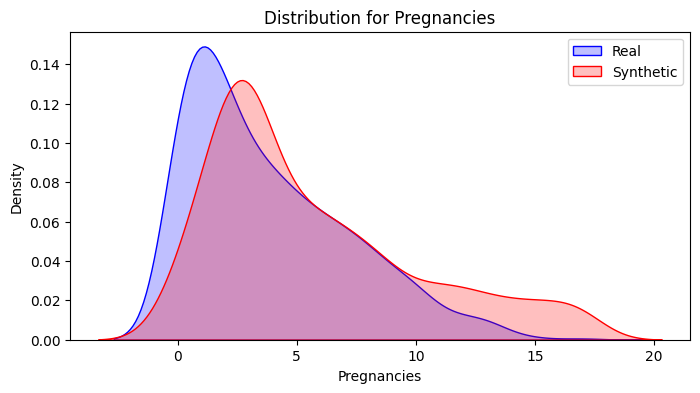

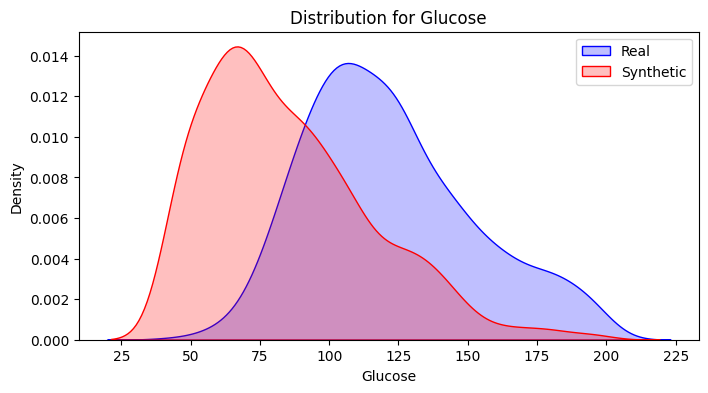

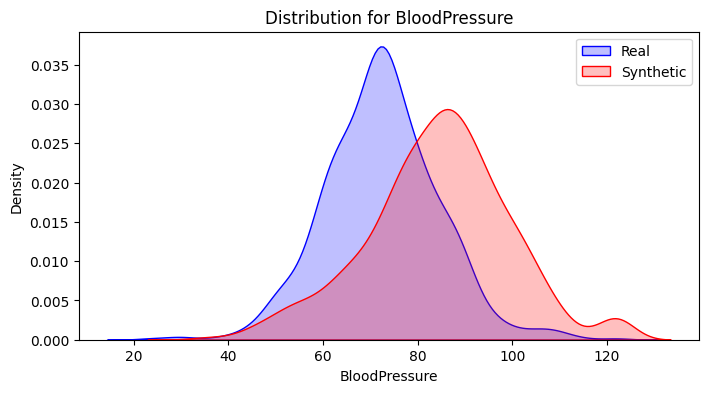

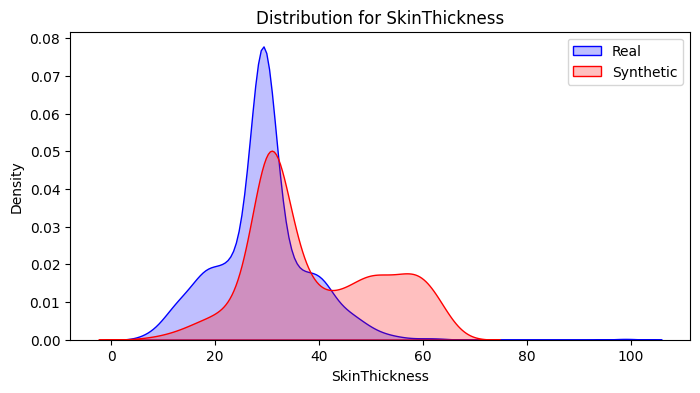

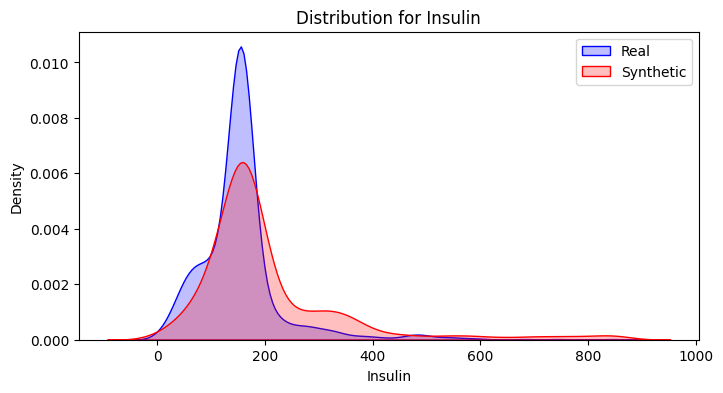

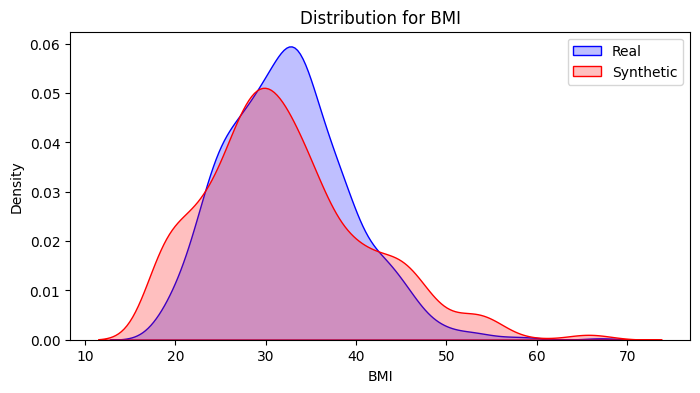

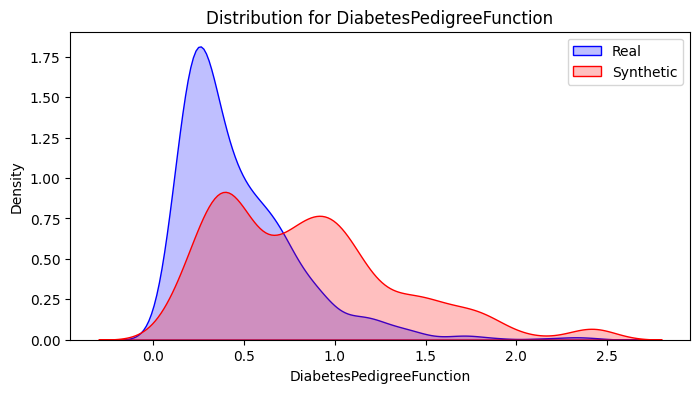

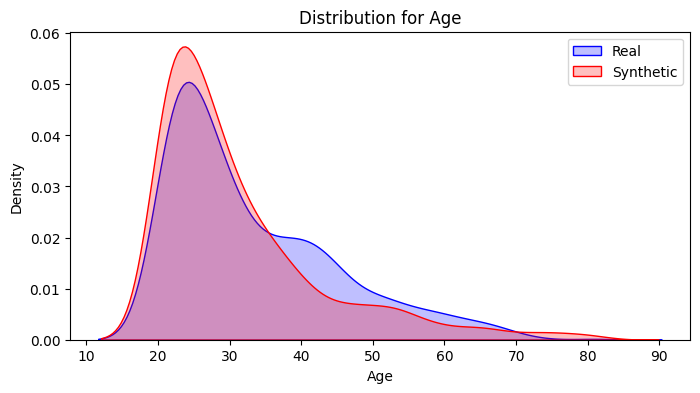

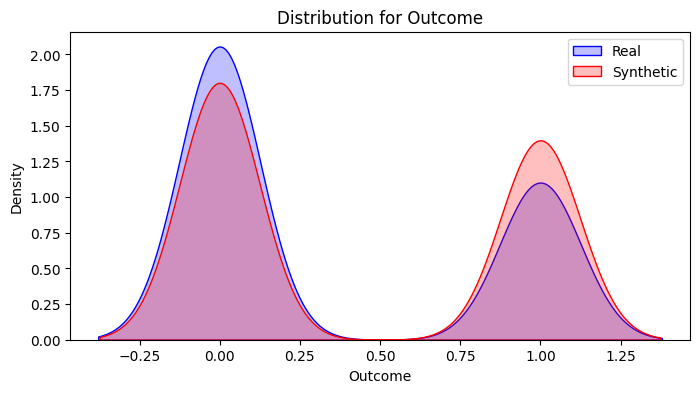

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose:
# - real_data = your original dataset
# - synthetic_data = data generated by CTGAN

# Only select numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns

for col in numeric_columns:
    plt.figure(figsize=(8,4))

    sns.kdeplot(data[col], label='Real', fill=True, color='blue')
    sns.kdeplot(synthetic_data[col], label='Synthetic', fill=True, color='red')

    plt.title(f'Distribution for {col}')
    plt.legend()
    plt.show()



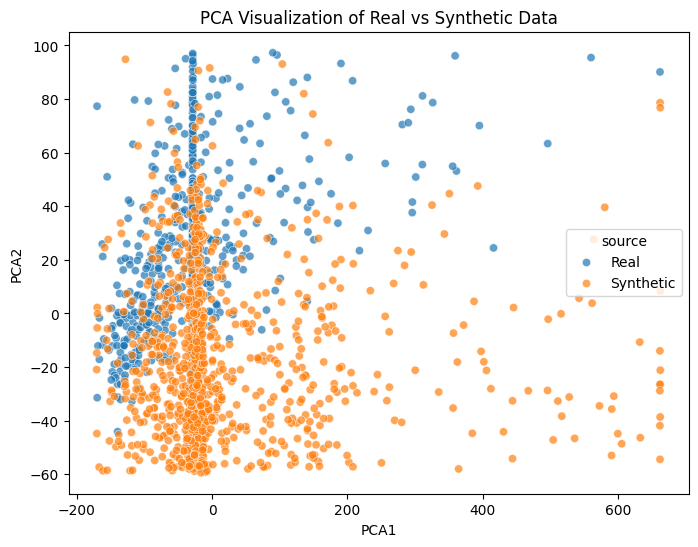

In [24]:
from sklearn.decomposition import PCA

# Combine data
data['source'] = 'Real'
synthetic_data['source'] = 'Synthetic'

combined = pd.concat([data, synthetic_data])

# Drop 'Outcome' if needed
features = combined.drop(['source'], axis=1)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

combined['PCA1'] = pca_result[:,0]
combined['PCA2'] = pca_result[:,1]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=combined, x='PCA1', y='PCA2', hue='source', alpha=0.7)
plt.title('PCA Visualization of Real vs Synthetic Data')
plt.show()


In [20]:
# Assuming your trained model is called 'ctgan'
model.save('ctgan_model.pkl')
